# Launch Sites Locations Analysis with Folium


In the previous exploratory data analysis labs, we have visualized the SpaceX launch dataset using matplotlib and seaborn and discovered some preliminary correlations between the launch site and success rates. In this lab, we will be performing more interactive visual analytics using Folium.

# Objectives
This lab contains the following tasks:

## TASK 1: Mark all launch sites on a map
## TASK 2: Mark the success/failed launches for each site on the map
## TASK 3: Calculate the distances between a launch site to its proximities
After completed the above tasks, you should be able to find some geographical patterns about launch sites.

Let's first import required Python packages for this lab:

In [1]:
!pip3 install folium
!pip3 install wget

  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9672 sha256=618537f1535c51c78a1c73c781b935a38b305a4f38ddca977733d952a01e1ff1
  Stored in directory: c:\users\madinalaptops\appdata\local\pip\cache\wheels\04\5f\3e\46cc37c5d698415694d83f607f833f83f0149e49b3af9d0f38
Successfully built wget


In [2]:
import folium
import wget
import pandas as pd

In [3]:
# Import folium MarkerCluster plugin
from folium.plugins import MarkerCluster
# Import folium MousePosition plugin
from folium.plugins import MousePosition
# Import folium DivIcon plugin
from folium.features import DivIcon

# Task 1: Mark all launch sites on a map
First, let's try to add each site's location on a map using site's latitude and longitude coordinates

The following dataset with the name spacex_launch_geo.csv is an augmented dataset with latitude and longitude added for each site.

In [4]:
# Download and read the `spacex_launch_geo.csv`
spacex_csv_file = wget.download('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/spacex_launch_geo.csv')
spacex_df=pd.read_csv(spacex_csv_file)
spacex_df.to_csv('spacex_launch_geo.csv')

100% [................................................................................] 7710 / 7710

Now, you can take a look at what are the coordinates for each site.

In [5]:
# Select relevant sub-columns: `Launch Site`, `Lat(Latitude)`, `Long(Longitude)`, `class`
spacex_df = spacex_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df = spacex_df.groupby(['Launch Site'], as_index=False).first()
launch_sites_df = launch_sites_df[['Launch Site', 'Lat', 'Long', 'class']]
launch_sites_df

,Launch Site,Lat,Long,class
0,CCAFS LC-40,28.562302,-80.577356,0
1,CCAFS SLC-40,28.563197,-80.576820,1
2,KSC LC-39A,28.573255,-80.646895,1
3,VAFB SLC-4E,34.632834,-120.610745,0


Above coordinates are just plain numbers that can not give you any intuitive insights about where are those launch sites. If you are very good at geography, you can interpret those numbers directly in your mind. If not, that's fine too. Let's visualize those locations by pinning them on a map.

We first need to create a folium Map object, with an initial center location to be NASA Johnson Space Center at Houston, Texas.

In [6]:
# Start location is NASA Johnson Space Center
nasa_coordinate = [29.559684888503615, -95.0830971930759]
site_map = folium.Map(location=nasa_coordinate, zoom_start=10)

We could use folium.Circle to add a highlighted circle area with a text label on a specific coordinate. For example,

In [10]:
# Create a blue circle at NASA Johnson Space Center's coordinate with a popup label showing its name
circle = folium.Circle(nasa_coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup('NASA Johnson Space Center'))
# Create a blue circle at NASA Johnson Space Center's coordinate with a icon showing its name
marker = folium.map.Marker(
    nasa_coordinate,
    # Create an icon as a text label
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % 'NASA JSC',
        )
    )
site_map.add_child(circle)
site_map.add_child(marker)

and you should find a small yellow circle near the city of Houston and you can zoom-in to see a larger circle.


Now, let's add a circle for each launch site in data frame launch_sites

TODO: Create and add folium.Circle and folium.Marker for each launch site on the site map

An example of folium.Circle:

folium.Circle(coordinate, radius=1000, color='#000000', fill=True).add_child(folium.Popup(...))

An example of folium.Marker:

folium.map.Marker(coordinate, icon=DivIcon(icon_size=(20,20),icon_anchor=(0,0), html='

%s
' % 'label', ))

In [11]:
# Initial the map
site_map = folium.Map(location=nasa_coordinate, zoom_start=5)
# For each launch site, add a Circle object based on its coordinate (Lat, Long) values. In addition, add Launch site name as a popup label
for lat, lng, label in zip(launch_sites_df['Lat'], launch_sites_df['Long'], launch_sites_df['Launch Site']):
    coordinate = [lat, lng]
    circle = folium.Circle(coordinate, radius=1000, color='#d35400', fill=True).add_child(folium.Popup(label))
    marker = folium.map.Marker(
        coordinate, 
        icon=DivIcon(
            icon_size=(20,20),
            icon_anchor=(0,0), 
            html='%s' % label, 
            )
        )
    site_map.add_child(circle)
    site_map.add_child(marker)

site_map

# Task 2: Mark the success/failed launches for each site on the map
Next, let's try to enhance the map by adding the launch outcomes for each site, and see which sites have high success rates. Recall that data frame spacex_df has detailed launch records, and the class column indicates if this launch was successful or not

In [13]:
spacex_df.tail(10)

,Launch Site,Lat,Long,class
46,KSC LC-39A,28.573255,-80.646895,1
47,KSC LC-39A,28.573255,-80.646895,1
48,KSC LC-39A,28.573255,-80.646895,1
49,CCAFS SLC-40,28.563197,-80.576820,1
50,CCAFS SLC-40,28.563197,-80.576820,1
51,CCAFS SLC-40,28.563197,-80.576820,0
52,CCAFS SLC-40,28.563197,-80.576820,0
53,CCAFS SLC-40,28.563197,-80.576820,0
54,CCAFS SLC-40,28.563197,-80.576820,1
55,CCAFS SLC-40,28.563197,-80.576820,0


Next, let's create markers for all launch records. If a launch was successful (class=1), then we use a green marker and if a launch was failed, we use a red marker (class=0)

Note that a launch only happens in one of the four launch sites, which means many launch records will have the exact same coordinate. Marker clusters can be a good way to simplify a map containing many markers having the same coordinate.

Let's first create a MarkerCluster object

In [14]:
marker_cluster = MarkerCluster()

TODO: Create a new column in launch_sites dataframe called marker_color to store the marker colors based on the class value

In [15]:
# Apply a function to check the value of `class` column
# If class=1, marker_color value will be green
# If class=0, marker_color value will be red
def assign_marker_color_LSDF(launch_class):
    if launch_class == 1:
        return 'green'
    else:
        return 'red'

launch_sites_df['marker_color'] = launch_sites_df['class'].apply(assign_marker_color_LSDF)
launch_sites_df

,Launch Site,Lat,Long,class,marker_color
0,CCAFS LC-40,28.562302,-80.577356,0,red
1,CCAFS SLC-40,28.563197,-80.576820,1,green
2,KSC LC-39A,28.573255,-80.646895,1,green
3,VAFB SLC-4E,34.632834,-120.610745,0,red


In [16]:
# Function to assign color to launch outcome
def assign_marker_color(launch_outcome):
    if launch_outcome == 1:
        return 'green'
    else:
        return 'red'
    
spacex_df['marker_color'] = spacex_df['class'].apply(assign_marker_color)
spacex_df.tail(10)

,Launch Site,Lat,Long,class,marker_color
46,KSC LC-39A,28.573255,-80.646895,1,green
47,KSC LC-39A,28.573255,-80.646895,1,green
48,KSC LC-39A,28.573255,-80.646895,1,green
49,CCAFS SLC-40,28.563197,-80.576820,1,green
50,CCAFS SLC-40,28.563197,-80.576820,1,green
51,CCAFS SLC-40,28.563197,-80.576820,0,red
52,CCAFS SLC-40,28.563197,-80.576820,0,red
53,CCAFS SLC-40,28.563197,-80.576820,0,red
54,CCAFS SLC-40,28.563197,-80.576820,1,green
55,CCAFS SLC-40,28.563197,-80.576820,0,red


TODO: For each launch result in spacex_df data frame, add a folium.Marker to marker_cluster

In [17]:
# Add marker_cluster to current site_map
site_map.add_child(marker_cluster)

# for each row in spacex_df data frame
# create a Marker object with its coordinate
# and customize the Marker's icon property to indicate if this launch was successed or failed, 
# e.g., icon=folium.Icon(color='white', icon_color=row['marker_color']
for lat, lng, label, color in zip(spacex_df['Lat'], spacex_df['Long'], spacex_df['Launch Site'], spacex_df['marker_color']):
    # TODO: Create and add a Marker cluster to the site map
    # marker = folium.Marker(...)
    coordinate = [lat, lng]
    marker = folium.Marker(
        coordinate, 
        icon=folium.Icon(color='white', icon_color=color),
        popup=label
    )
    marker_cluster.add_child(marker)

site_map

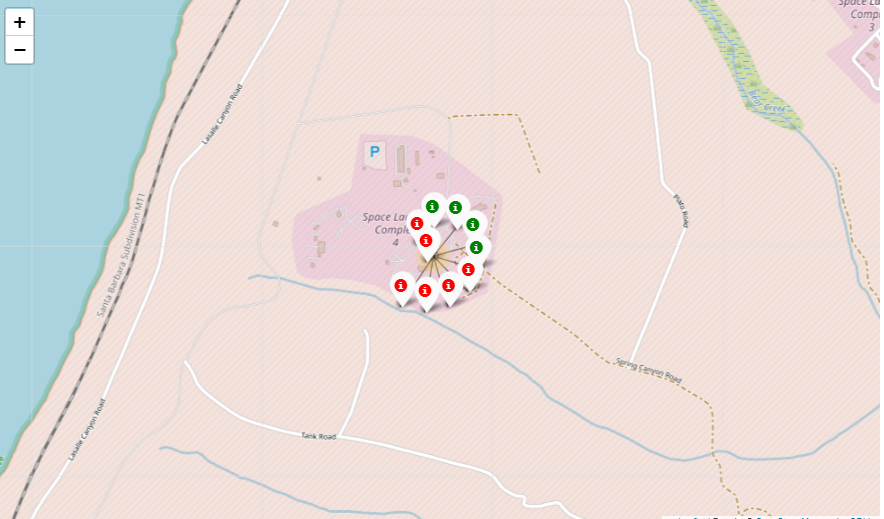

# TASK 3: Calculate the distances between a launch site to its proximities
Next, we need to explore and analyze the proximities of launch sites.

Let's first add a MousePosition on the map to get coordinate for a mouse over a point on the map. As such, while you are exploring the map, you can easily find the coordinates of any points of interests (such as railway)

In [18]:
# Add Mouse Position to get the coordinate (Lat, Long) for a mouse over on the map
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position)
site_map

You can calculate the distance between two points on the map based on their Lat and Long values using the following method: 

In [19]:
from math import sin, cos, sqrt, atan2, radians

def calculate_distance(lat1, lon1, lat2, lon2):
    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance

TODO: Mark down a point on the closest coastline using MousePosition and calculate the distance between the coastline point and the launch site.

In [20]:
# find coordinate of the closet coastline
# e.g.,: Lat: 28.56367  Lon: -80.57163
# distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)
coastline_lat = 28.56222
coastline_lon = -80.56809
launch_site_lat = 28.56321
launch_site_lon = -80.57683
distance_coastline = calculate_distance(launch_site_lat, launch_site_lon, coastline_lat, coastline_lon)

TODO: After obtained its coordinate, create a folium.Marker to show the distance

In [32]:
# Create and add a folium.Marker on your selected closest coastline point on the map
# Display the distance between coastline point and launch site using the icon property 
# for example
# distance_marker = folium.Marker(
#    coordinate,
#    icon=DivIcon(
#        icon_size=(20,20),
#        icon_anchor=(0,0),
#        html='
#%s
#' % "{:10.2f} KM".format(distance),
#        )
#    )
coast_coordinates = [coastline_lat, coastline_lon]
distance_marker = folium.Marker(
    coast_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_coastline),
        )
    )
distance_marker.add_to(site_map)
site_map

TODO: Draw a PolyLine between a launch site to the selected coastline point

In [34]:
# Create a `folium.PolyLine` object using the coastline coordinates and launch site coordinate
# lines=folium.PolyLine(locations=coordinates, weight=1)
launch_site_coordinates = [launch_site_lat, launch_site_lon]
lines=folium.PolyLine(locations=[coast_coordinates, launch_site_coordinates], weight=1)
site_map.add_child(lines)

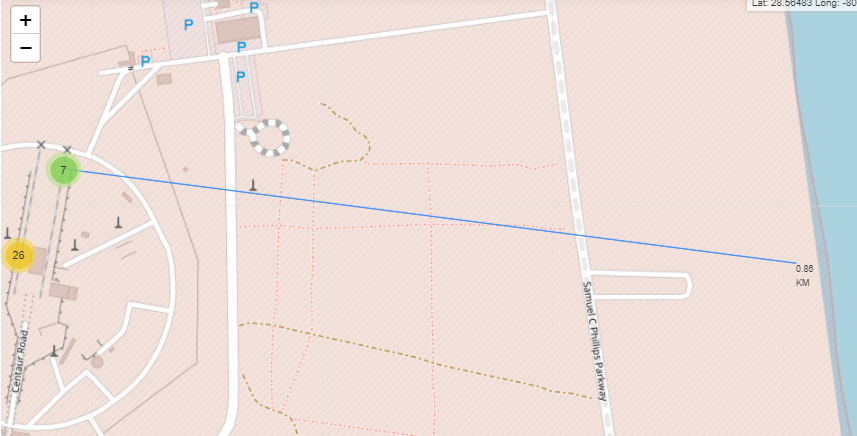

TODO: Similarly, you can draw a line betwee a launch site to its closest city, railway, highway, etc. You need to use MousePosition to find the their coordinates on the map first

In [36]:
# Create a marker with distance to a closest city, railway, highway, etc.
# Draw a line between the marker to the launch site
# Draw a line between the closest city(Titusville) to the launch site
city_lat = 28.61208
city_lon = -80.80764
distance_city = calculate_distance(launch_site_lat, launch_site_lon, city_lat, city_lon)

city_coordinates = [city_lat, city_lon]
distance_marker = folium.Marker(
    city_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_city),
        )
    )
distance_marker.add_to(site_map)

launch_site_coordinates = [launch_site_lat, launch_site_lon]
lines=folium.PolyLine(locations=[city_coordinates, launch_site_coordinates], weight=1)
site_map.add_child(lines)
site_map

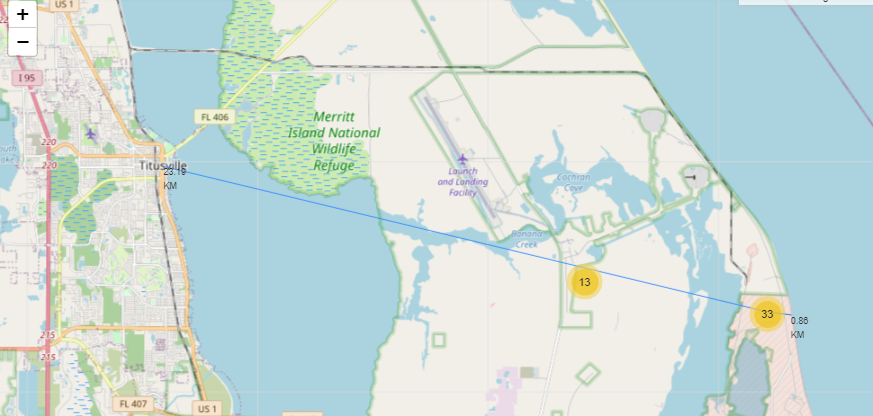

In [38]:
# Draw a line between the closest railway to the launch site
railway_lat = 28.57208
railway_lon = -80.58527
distance_railway = calculate_distance(launch_site_lat, launch_site_lon, railway_lat, railway_lon)

railway_coordinates = [railway_lat, railway_lon]
distance_marker = folium.Marker(
    railway_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_railway),
        )
    )
distance_marker.add_to(site_map)

launch_site_coordinates = [launch_site_lat, launch_site_lon]
lines=folium.PolyLine(locations=[railway_coordinates, launch_site_coordinates], weight=1)
site_map.add_child(lines)
site_map

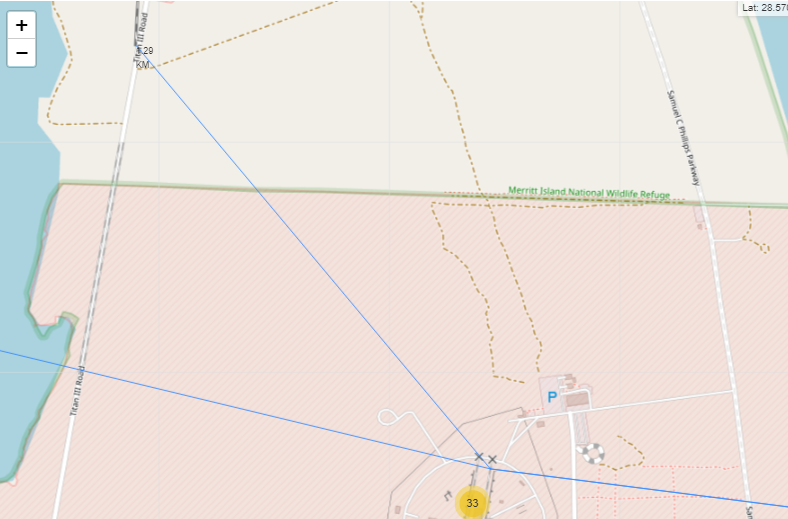

In [39]:
# Draw a line between the closest highway to the launch site
highway_lat = 28.56478
highway_lon = -80.57103
distance_highway = calculate_distance(launch_site_lat, launch_site_lon, highway_lat, highway_lon)

highway_coordinates = [highway_lat, highway_lon]
distance_marker = folium.Marker(
    highway_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_highway),
        )
    )
distance_marker.add_to(site_map)

launch_site_coordinates = [launch_site_lat, launch_site_lon]
lines=folium.PolyLine(locations=[highway_coordinates, launch_site_coordinates], weight=1)
site_map.add_child(lines)
site_map

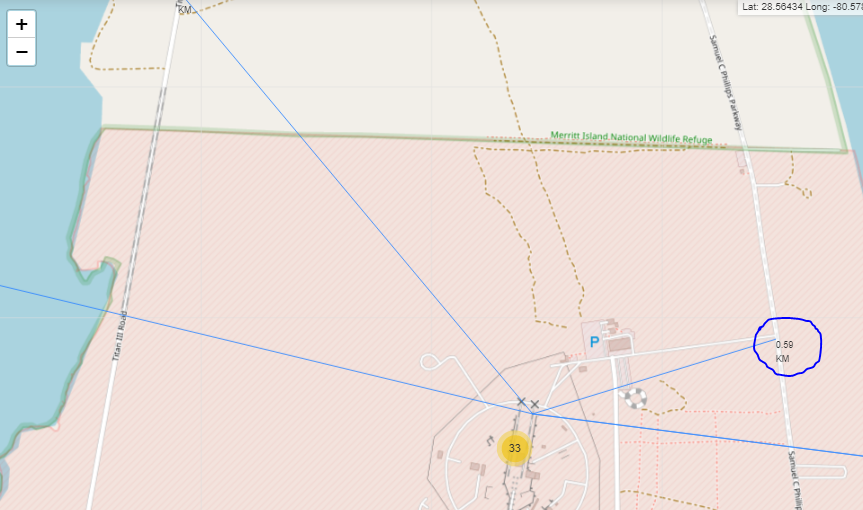

In [40]:
# Draw a line between the closest city(Cape Canaveral) to the launch site
city_2_lat = 28.40159
city_2_lon = -80.6042
distance_city_2 = calculate_distance(launch_site_lat, launch_site_lon, city_2_lat, city_2_lon)

city_2_coordinates = [city_2_lat, city_2_lon]
distance_marker = folium.Marker(
    city_2_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_city_2),
        )
    )
distance_marker.add_to(site_map)

launch_site_coordinates = [launch_site_lat, launch_site_lon]
lines=folium.PolyLine(locations=[city_2_coordinates, launch_site_coordinates], weight=1)
site_map.add_child(lines)
site_map

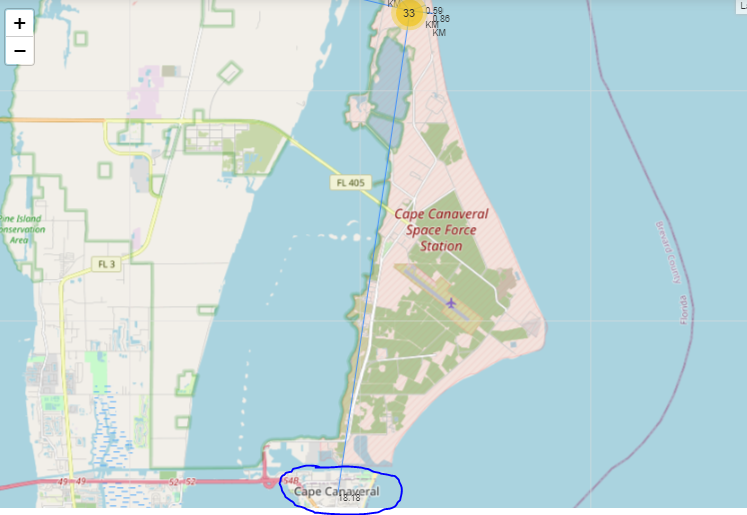

In [41]:
# Draw a line between the closest city(Lompoc) to the launch site(Space Launch Complex 4)
launch_site_4_lat = 34.63286
launch_site_4_lon = -120.61074
launch_site_4_coordinates = [launch_site_4_lat, launch_site_4_lon]

city_Lompoc_lat = 34.63879
city_Lompoc_lon = -120.45788
distance_city_Lompoc = calculate_distance(launch_site_4_lat, launch_site_4_lon, city_Lompoc_lat, city_Lompoc_lon)

city_Lompoc_coordinates = [city_Lompoc_lat, city_Lompoc_lon]

distance_marker = folium.Marker(
    city_Lompoc_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_city_Lompoc),
        )
    )
distance_marker.add_to(site_map)

lines=folium.PolyLine(locations=[city_Lompoc_coordinates, launch_site_4_coordinates], weight=1)
site_map.add_child(lines)

# Draw a line between the closest coast to the launch site(Space Launch Complex 4)
west_coast_lat = 34.63698
west_coast_lon = -120.6245
distance_west_coast = calculate_distance(launch_site_4_lat, launch_site_4_lon, west_coast_lat, west_coast_lon)

west_coast_coordinates = [west_coast_lat, west_coast_lon]

distance_marker = folium.Marker(
    west_coast_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_west_coast),
        )
    )
distance_marker.add_to(site_map)

lines=folium.PolyLine(locations=[west_coast_coordinates, launch_site_4_coordinates], weight=1)
site_map.add_child(lines)

# Draw a line between the closest railway to the launch site(Space Launch Complex 4)
railway_4_lat = 34.63677
railway_4_lon = -120.6236
distance_railway_4 = calculate_distance(launch_site_4_lat, launch_site_4_lon, railway_4_lat, railway_4_lon)

railway_4_coordinates = [railway_4_lat, railway_4_lon]

distance_marker = folium.Marker(
    railway_4_coordinates,
    icon=DivIcon(
        icon_size=(20,20),
        icon_anchor=(0,0),
        html='%s' % "{:10.2f} KM".format(distance_railway_4),
        )
    )
distance_marker.add_to(site_map)

lines=folium.PolyLine(locations=[railway_4_coordinates, launch_site_4_coordinates], weight=1)
site_map.add_child(lines)

site_map

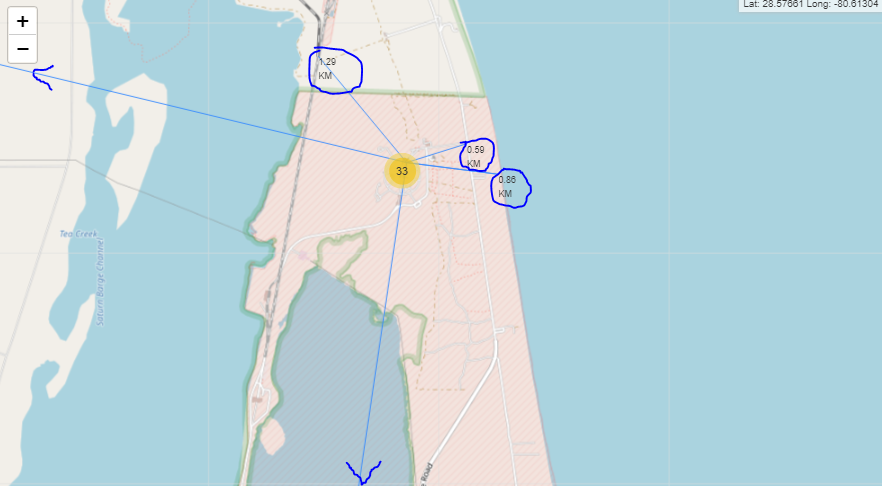

## After you plot distance lines to the proximities, you can answer the following questions easily:

Are launch sites in close proximity to railways?

YES, it is close to railway at distance of 1.29KM.


Are launch sites in close proximity to highways?

YES, it is very close to highway at distance of 0.59KM.


Are launch sites in close proximity to coastline?

YES it is, distance between launch site and coastline is 0.86KM.


Do launch sites keep certain distance away from cities?

yes launch site is at distacne of 18.8KM away from cities.